In [1]:
cd

/home/luxx0489


In [2]:
# import packages
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from mne.io import read_raw_edf
from mne.viz import plot_evoked_topo, plot_evoked
from scipy.signal import welch,periodogram
from anlffr import spectral
from scipy.io import loadmat, savemat
from matplotlib.colors import from_levels_and_colors

#%matplotlib qt

/home/luxx0489/.conda/envs/mne/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
ID_list = [6,7,8,9,10,12,13,14,16,17,18,19,20,21,22]
Freq_list = [43.43, 98.28,34.28, 91.42,45,100]

output = np.empty((len(ID_list)*2*len(Freq_list),71))
# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98), PLV*66 (64 channels+mastoid)

row_num = 0

for iSubject in [6]:# ID_list:# range(2,18):

    folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/"
    sub_id = 'Sub' + str(iSubject) + '_LF'
    raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                   stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
    events = mne.find_events(raw)

    epochs = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
    epochs.load_data()
    ep_m = epochs.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])
    ep_a = epochs.copy().set_eeg_reference(ref_channels='average')

    data = ep_a.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_a = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_a = abs((xw_a/abs(xw_a)).mean(0))
    
    data = ep_m.get_data()[:,:,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]   
    linked_mastoid = data[:,64:66,:].mean(1)
    diff_horizontal = data[:,64,:] - data[:,65,:]
    refs = np.dstack((linked_mastoid,diff_horizontal)).transpose(0,2,1)
    data_wref = np.concatenate((data,refs),axis=1)
    xw_m = np.fft.rfft(np.hamming(data.shape[2])*data_wref, axis=2)
    plv_m = abs((xw_m/abs(xw_m)).mean(0))
    
    freq = np.fft.rfftfreq(data.shape[2],1/4096)
    
    for iFreq in range(len(Freq_list)):
        index = np.argmin(abs(freq-Freq_list[iFreq]))

        output[row_num,0] = iSubject
        output[row_num,1] = 0
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_a[0:66,index]
        output[row_num,69:71] = plv_a[67:69,index]
        
        row_num +=1
        
        output[row_num,0] = iSubject
        output[row_num,1] = 1
        output[row_num,2] = Freq_list[iFreq]
        output[row_num,3:69] = plv_m[0:66,index]
        output[row_num,69:71] = plv_m[67:69,index]

        row_num +=1

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [8]:
plv_m

array([[0.032     , 0.15363275, 0.14778082, ..., 0.03510443, 0.02757509,
        0.022     ],
       [0.056     , 0.13419533, 0.14249287, ..., 0.02221749, 0.01393185,
        0.008     ],
       [0.096     , 0.21353099, 0.21151624, ..., 0.05572543, 0.03806206,
        0.048     ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.87044461, 0.84942675,
        0.772     ],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.034     , 0.03287758, 0.04150756, ..., 0.01413778, 0.03073615,
        0.026     ]])

In [45]:
from sklearn.decomposition import PCA
plv_t = plv_m
pca = PCA(n_components = 10)
pca.fit(plv_t[0:64,:].T)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

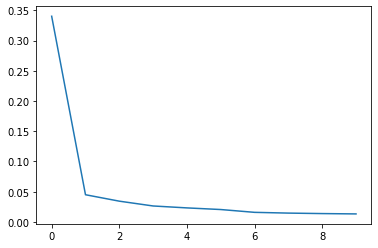

In [46]:
plt.plot(pca.explained_variance_ratio_)

(30, 200)

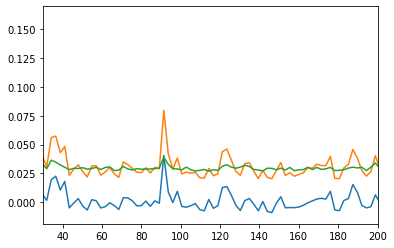

In [50]:
results = pca.transform(plv_t[0:64,:].T)
results.shape
plt.plot(freq,results[:,0]/10)
plt.plot(freq,plv_t[0:64,:].mean(0))

plt.plot(freq,plv_t[0:64,:].mean(0)-results[:,0]/10)
plt.xlim(30,200)

                                         ID             A1             A2  \
reference      frequency                                                    
5e-324         4.685791e-310  1.697597e-313  4.685939e-310  6.925902e-310   
               4.685939e-310  8.487983e-314  1.383384e-322  6.925849e-310   
               6.925849e-310  2.334195e-313  5.928788e-323  6.925850e-310   
1e-323         4.685939e-310  6.790387e-313  4.685939e-310  4.685791e-310   
2e-323         4.685936e-310   0.000000e+00  6.925849e-310  9.881313e-324   
...                                     ...            ...            ...   
linked mastoid 4.343000e+01    6.000000e+00   6.544890e-03   2.196824e-02   
               4.500000e+01    6.000000e+00   2.222573e-02   2.909808e-02   
               9.142000e+01    6.000000e+00   4.133207e-02   6.354855e-02   
               9.828000e+01    6.000000e+00   3.861158e-02   2.434686e-02   
               1.000000e+02    6.000000e+00   3.252042e-02   1.541788e-02   

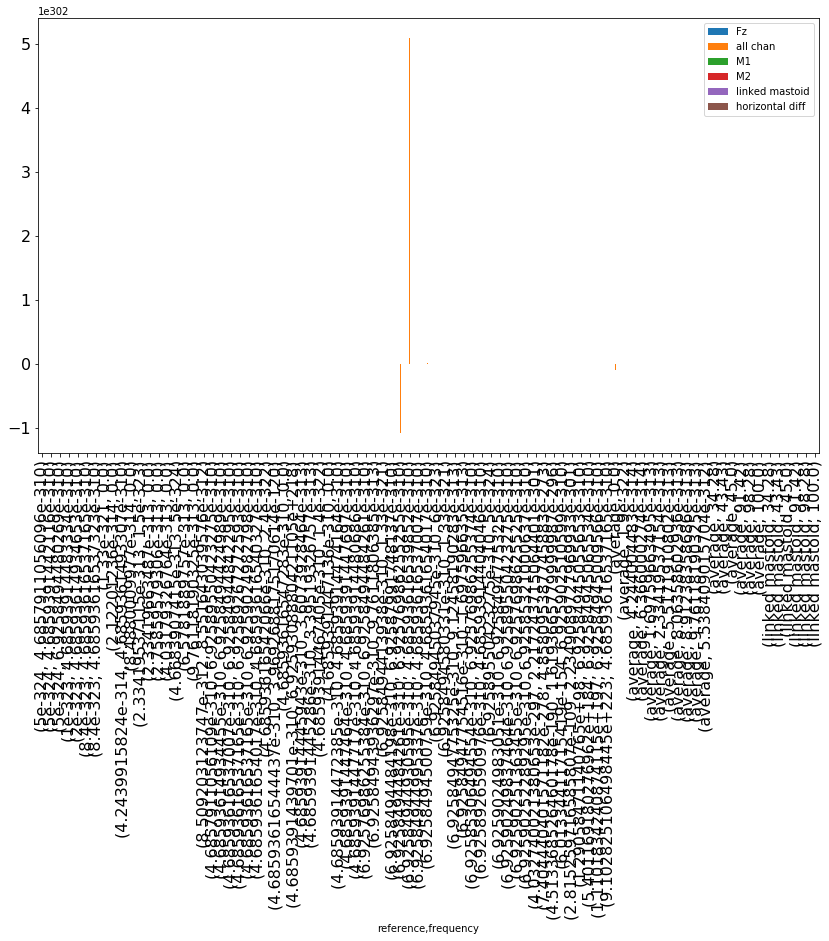

In [5]:
df = pd.DataFrame(output,columns=['ID','reference','frequency']
                  + epochs.info['ch_names'][0:66] + ['linked mastoid','horizontal diff'])
df.head()

dictionary = {0:'average',1:'linked mastoid'}

df_f = df.copy().replace({'reference':dictionary})

df_f['all chan'] = df_f.loc[:,'A1':'B32'].mean(axis=1)
df_f['Fz'] = df_f['B6']
df_f['M1'] = df_f['EXG1']
df_f['M2'] = df_f['EXG2']
df_group = df_f.groupby(by=['reference','frequency'])
df_avg = df_group.mean()
df_std = df_group.std()/np.sqrt(len(ID_list))
df_avg.drop(columns='ID')
print(df_avg)

p = df_avg[['Fz','all chan','M1','M2','linked mastoid','horizontal diff']].plot(kind='bar',yerr=df_std,figsize = (14,8),fontsize=16)


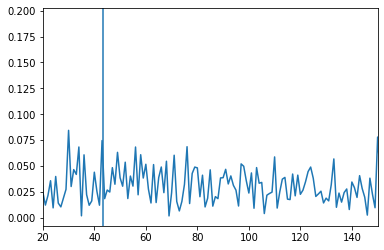

In [101]:
n_channel = 37
index = np.argmin(abs(freq-Freq_list[0]))
plt.plot(plv_a[37,:])
plt.xlim(20,150)
plt.axvline(freq[index])

(-0.001, 0.001)

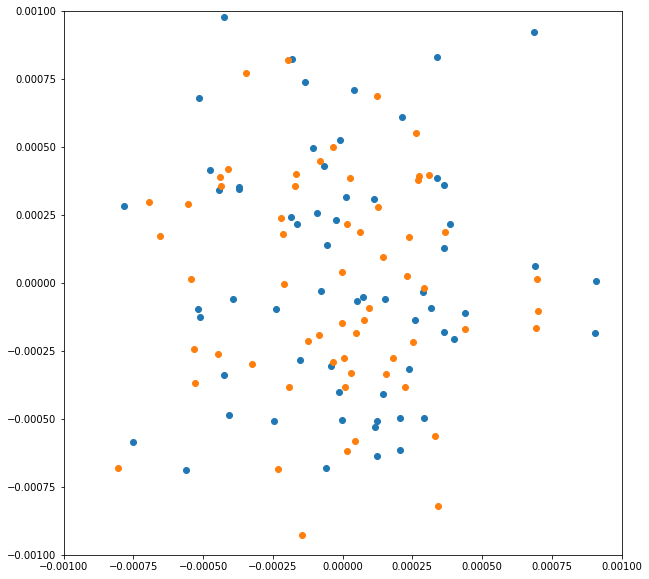

In [54]:
ch_n = 40
phase_m=xw_m[:,ch_n,index]
phase_a = xw_a[:,ch_n,index]
plt.figure(figsize=(10,10))
#phase_m = xw_m.mean(0)[:,index]
#phase_a = xw_a.mean(0)[:,index]
plt.scatter(np.real(phase_m[0:64]),np.imag(phase_m[0:64]),label='EEG channel (Mastoid ref)')
plt.scatter(np.real(phase_a[0:64]),np.imag(phase_a[0:64]),label='Mastoid channel (AVE ref)')
scale = 0.001
plt.xlim(-scale,scale)
plt.ylim(-scale,scale)

(-0.001, 0.001)

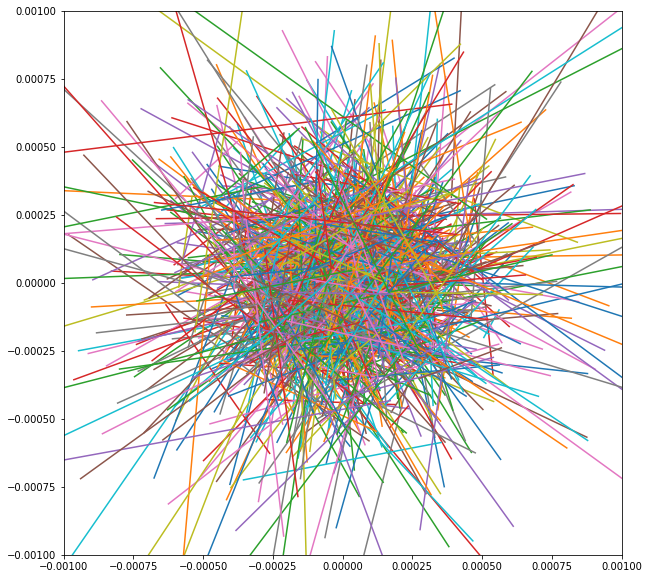

In [68]:
ch_n_1 = 37
ch_n_2 = 50
phase_m=xw_a[:,ch_n_1,index+5]
phase_a = xw_a[:,ch_n_2,index+5]
plt.figure(figsize=(10,10))
#phase_m = xw_m.mean(0)[:,index]
#phase_a = xw_a.mean(0)[:,index]
for i in range(1000):
    plt.plot([np.real(phase_m[i]),np.real(phase_a[i])],[np.imag(phase_m[i]),np.imag(phase_a[i])])

scale = 0.001
plt.xlim(-scale,scale)
plt.ylim(-scale,scale)

0.022598448724414806

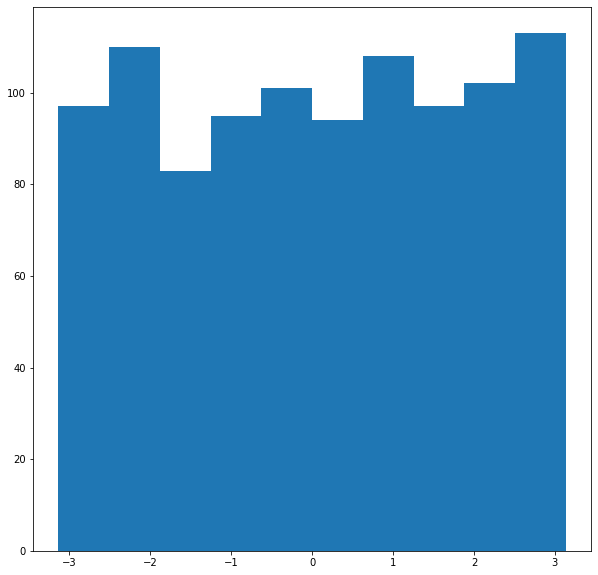

In [73]:
ch_n_1 = 37
ch_n_2 = 50
phase_m=xw_a[:,ch_n_1,index]
phase_a = xw_a[:,ch_n_2,index]
plt.figure(figsize=(10,10))
#phase_m = xw_m.mean(0)[:,index]
#phase_a = xw_a.mean(0)[:,index]
plt.hist(np.angle(phase_m-phase_a))
np.abs(sum((phase_m-phase_a)/np.abs(phase_m-phase_a)))/1000
#scale = 0.001
#plt.xlim(-scale,scale)
#plt.ylim(-scale,scale)

(array([  2.,   7.,  12.,  54., 179., 428., 241.,  36.,  31.,  10.]),
 array([-11.96797568, -11.25279574, -10.53761579,  -9.82243585,
         -9.10725591,  -8.39207597,  -7.67689603,  -6.96171608,
         -6.24653614,  -5.5313562 ,  -4.81617626]),
 <a list of 10 Patch objects>)

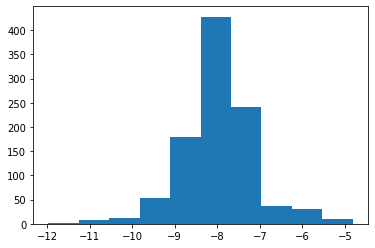

In [103]:
plt.hist(np.log(abs(xw_m[:,37,index])))

(array([ 91.,  88.,  96.,  85.,  97.,  89., 100., 108., 120., 126.]),
 array([-3.13065256, -2.50356695, -1.87648134, -1.24939573, -0.62231012,
         0.0047755 ,  0.63186111,  1.25894672,  1.88603233,  2.51311794,
         3.14020356]),
 <a list of 10 Patch objects>)

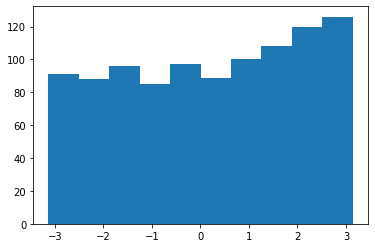

In [104]:
plt.hist(np.angle(xw_m[:,37,index]))

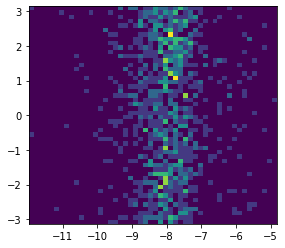

In [108]:
x=np.log(abs(xw_m[:,37,index]))
y=np.angle(xw_m[:,37,index])

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower')


In [53]:
plv

NameError: name 'plv' is not defined

In [14]:
phase_m.mean()

(5.269563266620498e-06-6.266916963159109e-06j)